In [1]:
from library import *
from constant import *

In [5]:
# NLP
nltk.download('punkt')
translator = Translator()
stopwords = set(STOPWORDS)
#add words frequently used in code description
stopwords.add('using')
stopwords.add('use')
stopwords.add('based')

[nltk_data] Downloading package punkt to
[nltk_data]     /nas/home/parisaka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Reading data 

In [6]:
repo_pd=pd.read_pickle('repo_owner_pd.pickle')
user_pd=pd.read_pickle('user_pandas.pickle')
#events from 2017 to 2019 are stored in this database
event_pd=pd.read_pickle('event_pandas.pickle')
# 2020 events are in this database
event_pd_2020=pd.read_pickle('event_pandas_2020.pickle')

In [7]:
#nan values to None
repo_pd = repo_pd.where(pd.notnull(repo_pd), None)

#### event data with payload

In [ ]:
event_pd=pd.read_pickle('event_pandas_.pickle')
event_pd_2020=pd.read_pickle('event_pandas_2020_.pickle')

#### merge events with 2020 events

In [8]:
frames=[event_pd, event_pd_2020]
event_pd=pd.concat(frames)

In [9]:
len(repo_pd), len(event_pd), len(user_pd)

(7424, 4938569, 284323)

#### filter out events for AI-repos

In [10]:
event_pd=event_pd[event_pd.repo_id.isin(set(repo_pd['repo_id']))]

In [11]:
len(event_pd)

2078098

#### Label repos at country level based on country of their contributors & majority rule

In [10]:
#country & company of contributors
#merge user_pd and event_pd on user_id/actor_id and return user_company and user_country
event_user_info=event_pd.merge(user_pd[['user_id', 'user_company', 'user_country']], left_on='actor_id', right_on='user_id', how='left')

In [11]:
#group by repo_id
repo_contributor_country=event_user_info[event_user_info['event_type']!='WatchEvent'][['repo_id', 'user_country']].groupby('repo_id')['user_country'].apply(list)
repo_contributor_company=event_user_info[event_user_info['event_type']!='WatchEvent'][['repo_id', 'user_company']].groupby('repo_id')['user_company'].apply(list)


In [12]:
#to dataFrame
repo_contributor_country=pd.DataFrame({'repo_id':repo_contributor_country.index, 'contributors_country':repo_contributor_country.values})
repo_contributor_company=pd.DataFrame({'repo_id':repo_contributor_company.index, 'contributors_company':repo_contributor_company.values})

In [13]:
#return the country/company of majority of contributors
def most_common(lst):
    #remove none values
    lst=[country for country in lst if country is not None and not pd.isnull(country)]
    if len(lst)>0:
        lst_count=Counter(lst)
        #apply majority rule
        return list(lst_count.keys())[0] if list(lst_count.values())[0] / len(lst) >= 0.5 else None
    else:
        return None


In [16]:
#pair of repo_id and country
repo_country=[(row[1]['repo_id'], most_common (row[1]['contributors_country'])) for row in repo_contributor_country.iterrows()]
#pair of repo_id and company
repo_company=[(row[1]['repo_id'], most_common (row[1]['contributors_company'])) for row in repo_contributor_company.iterrows()]


In [17]:
#tuple to dictionary
repo_country=dict(repo_country)
repo_company=dict(repo_company)

In [18]:
#for those repos w/o country/company based on majority rule --> country of owner
owner_country = dict(zip(repo_pd.repo_id, repo_pd.owner_country))
owner_company = dict(zip(repo_pd.repo_id, repo_pd.owner_company))

In [19]:
#add repo_country, repo_company cols to repo_pd
CounTry=[]
ComPany=[]
for row in repo_pd.iterrows():
    repo_id=row[1]['repo_id']
    #...... country .......
    if repo_country[repo_id]:
        CounTry.append(repo_country[repo_id])
    else:
        CounTry.append(owner_country[repo_id])
        
    #......... Company ........    
    if repo_company[repo_id]:
        ComPany.append(repo_company[repo_id])
    else:
        ComPany.append(owner_company[repo_id])

        
        

#### add new cols of repo_country and repo_company to repo_pd

In [20]:
#repo_pd['repo_country']=CounTry
#repo_pd['repo_company']=ComPany

In [22]:
#repo_pd.to_pickle('repo_owner_pd.pickle')

In [35]:
# 998 of repos has no known country of contributors
# 1749 majority rule does not apply
# 4677 of repos with country
# 942 of repos w/o country based on majority rule, have owners with known countries
# 4677+942 = 5619 repos with country
# 7424-5619= 1805 repos w/o country

In [25]:
#repo_pd[repo_pd.repo_company.notnull()]

#### get id of US & China repos

In [16]:
US_repo_ids=set(repo_pd[repo_pd.repo_country=='USA']['repo_id'])
China_repo_ids=set(repo_pd[repo_pd.repo_country=='China']['repo_id'])

### Clustering repos based on size (number of events/ number of users)

In [12]:
X=event_pd[event_pd.event_type!='WatchEvent'].repo_id.value_counts()
#make it to frame
repo_no_events=pd.DataFrame({'repo_id':X.index, 'num_events':X.values})

In [12]:
X=event_pd[event_pd.event_type!='WatchEvent'][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
#make it to frame
repo_no_users=pd.DataFrame({'repo_id':X.index, 'no_users':X.values})
repo_no_users['num_users'] = repo_no_users.apply(lambda row: len(set(row.no_users)), axis=1)
repo_no_users=repo_no_users.drop(['no_users'], axis=1)

<AxesSubplot:>

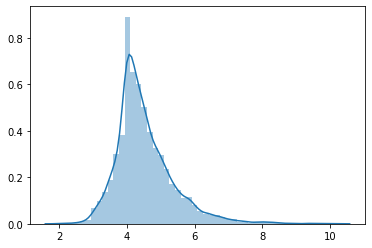

In [13]:
sns.distplot(list(np.log(repo_no_events['num_events'])), kde=True)

<AxesSubplot:>

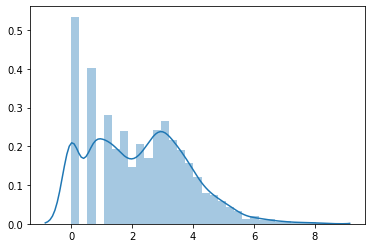

In [14]:
sns.distplot(np.log(list(repo_no_users['num_users'])), kde=True)

In [14]:
#cluster based on percentile of events (25%, 50%, 75% and 100% of repos)

def ClusterRepos(data, feature):
    repo_clusters=defaultdict(list)

    
    for row in data.iterrows():
        if row[1][feature] <= np.percentile(data[feature], 25):
            if row[1]['repo_id'] in US_repo_ids:
                repo_clusters['25_percentile_US'].append(row[1]['repo_id'])
            elif row[1]['repo_id'] in China_repo_ids:
                repo_clusters['25_percentile_China'].append(row[1]['repo_id'])
                

        elif row[1][feature] <= np.percentile(data[feature], 50):
            if row[1]['repo_id'] in US_repo_ids:
                repo_clusters['50_percentile_US'].append(row[1]['repo_id'])
            elif row[1]['repo_id'] in China_repo_ids:
                repo_clusters['50_percentile_China'].append(row[1]['repo_id'])


        elif row[1][feature] <= np.percentile(data[feature], 75):
            if row[1]['repo_id'] in US_repo_ids:
                repo_clusters['75_percentile_US'].append(row[1]['repo_id'])
            elif int(row[1]['repo_id']) in China_repo_ids:
                repo_clusters['75_percentile_China'].append(row[1]['repo_id'])


        else:
            if row[1]['repo_id'] in US_repo_ids:
                repo_clusters['100_percentile_US'].append(row[1]['repo_id'])
            elif row[1]['repo_id'] in China_repo_ids:
                repo_clusters['100_percentile_China'].append(row[1]['repo_id'])

        
        
    return repo_clusters

In [17]:
#repo_clusters_no_users=ClusterRepos(repo_no_users, 'num_users')
repo_clusters_no_events=ClusterRepos(repo_no_events, 'num_events')

In [18]:
for item in repo_clusters_no_events:
    print (item)
    print (len(repo_clusters_no_events[item]))
    print()

100_percentile_US
365

100_percentile_China
258

75_percentile_China
229

75_percentile_US
380

50_percentile_US
364

50_percentile_China
229

25_percentile_China
409

25_percentile_US
342



##### Question to ask --> why a lot of chines repos fall in small cluster

In [20]:
user_pd.user_company.value_counts()#many github users come from schools in China (both watchers and contributors)

Tsinghua University                          399
Microsoft                                    366
Peking University                            300
Google                                       264
Zhejiang University                          264
                                            ... 
SG Corporation                                 1
Wake Forest University School of Medicine      1
Qihoo 360 Technology Co.,Ltd                   1
@KiweeEu                                       1
Ruckus Wireless                                1
Name: user_company, Length: 38818, dtype: int64

In [59]:
#get company for repos in china small cluster
repo_china_small=repo_pd[repo_pd.repo_id.isin(repo_clusters_no_events['25_percentile_China'])][['repo_id', 'repo_company']]

In [62]:
#check how many of small repos in china are university-based (this function can be applied to any cluster across US and China)
ct=0
school_keywords=['University', 'university', 'School', 'school', 'Academy', 'Institute', 'lab', 'Laboratory', 'Lab']
for row in repo_china_small.iterrows():
    if row[1]['repo_company']:
        if any(s in row[1]['repo_company'] for s in school_keywords):
            ct+=1
print (len(repo_clusters_no_events['25_percentile_China']), ct)

409 121


## Explotary Analysis 

### 1) event distribution

In [30]:
event_pd[(event_pd.repo_id.isin(China_repo_ids)) & (event_pd.event_type!='WatchEvent')].event_type.value_counts(normalize=False)

ForkEvent                        57515
PushEvent                        48441
IssueCommentEvent                27318
IssuesEvent                      17027
PullRequestEvent                  5170
CreateEvent                       3602
PullRequestReviewCommentEvent      735
DeleteEvent                        647
GollumEvent                        419
MemberEvent                        262
ReleaseEvent                       215
CommitCommentEvent                 144
PublicEvent                         32
Name: event_type, dtype: int64

In [31]:
event_pd[(event_pd.repo_id.isin(US_repo_ids)) & (event_pd.event_type!='WatchEvent')].event_type.value_counts(normalize=False)

PushEvent                        109210
ForkEvent                         33885
IssueCommentEvent                 29563
IssuesEvent                       17970
PullRequestEvent                  16741
CreateEvent                       10821
PullRequestReviewCommentEvent      5322
DeleteEvent                        4862
MemberEvent                        1252
GollumEvent                         722
ReleaseEvent                        494
CommitCommentEvent                  322
PublicEvent                          53
Name: event_type, dtype: int64

### 2) Repo specific activities 

In [61]:
#frequent repos
frequent_repo=event_pd[event_pd['event_type']!='WatchEvent']['repo_id'].value_counts().head(40).to_dict()

In [62]:
US_repo=set(repo_pd[(repo_pd.repo_id.isin(frequent_repo)) & (repo_pd.repo_country=='USA')]['repo_id'].values)
china_repo=set(repo_pd[(repo_pd.repo_id.isin(frequent_repo)) & (repo_pd.repo_country=='China')]['repo_id'].values)

In [69]:
#distribution of events across top repositories
X=event_pd[event_pd.event_type!='WatchEvent'] # filter watch events
X_US=X[X['repo_id'].isin(US_repo)][['repo_id', 'event_type']]
X_China=X[X['repo_id'].isin(china_repo)][['repo_id', 'event_type']]

In [74]:
def event_dist(X, title):
    plt.style.use('ggplot')
    
    

    X.groupby(['repo_id','event_type']).size().groupby(level=0).apply(
        lambda x: 100 * x / x.sum()
    ).unstack().plot(kind='bar',stacked=True, legend=True)

    

    
    plt.legend(loc=(1.04,0), fontsize=12,  ncol = 5)
    plt.legend().remove()
    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
  
    
    plt.xticks([])
    #plt.yticks([])
    plt.ylabel('Event Type (%)', color='black', fontsize=15)
    #plt.xlabel('Top repositories (China)', color='black')
    plt.xlabel('')
    plt.tick_params(axis='x', colors='black')
    plt.tick_params(axis='y', colors='black')
    
    #plt.savefig('Plots/'+title+'.pdf')
    plt.savefig('Plots/' + title + '.pdf', bbox_inches='tight')

   
    plt.show()

distribution of events in top chinese repos

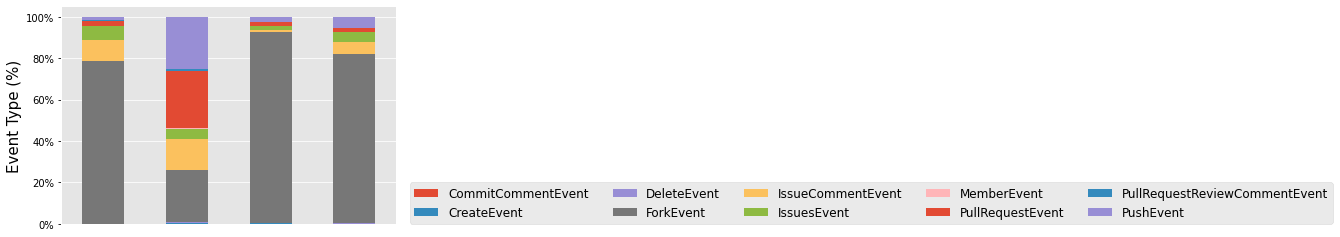

In [73]:
event_dist(X_China, 'top_china_repo')

distribution of events in top US repos

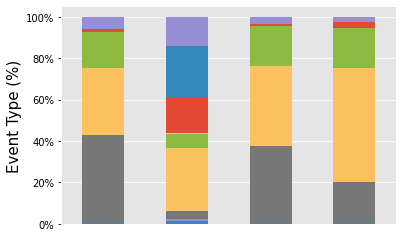

In [75]:
X_US=X_US[X_US.repo_id.isin({79841608, 90321822,120985410,  132042932})]
event_dist(X_US, 'top_USA_repo')

### 3) power law distribution

In [52]:
def Power_Law_plot(z, x_label, y_label, title):
    counts = np.array(list(z.keys()))
    freq_of_counts = np.array(list(z.values()))
    plt.scatter(np.log(counts), np.log(freq_of_counts), s=10)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show();
    

#### distribution of users activities (power law distribution)

In [53]:
user_activity_dist=event_pd[event_pd['event_type']!='WatchEvent']['actor_id'].value_counts().values
z=Counter(user_activity_dist)

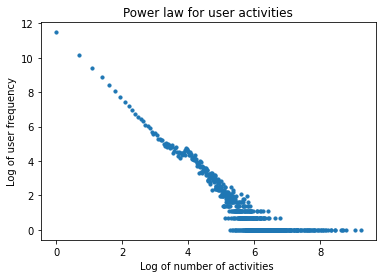

In [54]:
Power_Law_plot(z, 'Log of number of activities ', 'Log of user frequency', 'Power law for user activities')

#### distribution of repos activities (normal distribution)¶

In [55]:
repo_activity_dist=event_pd[event_pd['event_type']!='WatchEvent']['repo_id'].value_counts().values

In [57]:
#save number of events per repo
with open('repo_event_dist.txt', 'w') as f:
    for no_event in repo_activity_dist:
        if no_event<=1000:
            f.write(str(no_event))
            f.write('\n')
#         else:
#             f.write(str(1000))
#             f.write('\n')
f.close()

#### distribution of unique contributers to each repo (power law dist)

In [58]:
repo_unique_contributors_dist=event_pd[event_pd['event_type']!='WatchEvent'][['repo_id', 'actor_id']].drop_duplicates()['repo_id'].value_counts().values
z=Counter(repo_unique_contributors_dist)


In [60]:
#save number of contributors per repo
with open('repo_user_dist.pickle', 'wb') as handle:
    pickle.dump(z, handle, protocol=pickle.HIGHEST_PROTOCOL)

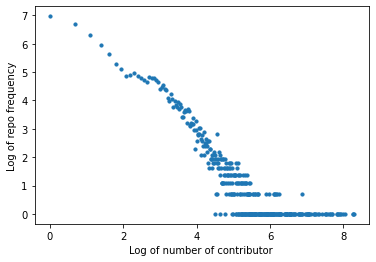

In [59]:
Power_Law_plot(z, 'Log of number of contributor ', 'Log of repo frequency', '')

### 4) word cloud

In [12]:
# get the repos description
China_descrip, US_descrip=defaultdict(), defaultdict()

for row in tqdm(event_pd.iterrows()):
    
    if row[1]['event_type']=='CreateEvent' and row[1]['event_payload']['ref_type']=='repository':
            if row[1]['repo_id'] in China_repo_ids:
                China_descrip[row[1]['repo_id']]=row[1]['event_payload']['description']
               
                
            elif row[1]['repo_id'] in US_repo_ids:
                US_descrip[row[1]['repo_id']]=row[1]['event_payload']['description']
                

            

2078098it [03:15, 10620.84it/s]


In [13]:
len(China_descrip), len(US_descrip), len(US_repo_ids), len(China_repo_ids)

(1125, 1451, 1451, 1125)

#### translate zh characters to English for a fair comparison 

In [14]:
# check for zh characters

# 42 number of chinese repos has zh characters in description
# 3 number of US repos has zh characters in description
def address_descriptions_w_zh_characters(descrip):
    ct=0
    for repo_id in descrip:
        a=descrip[repo_id]
        lan=langid.classify(a)
        if lan[0]=='zh':
            ct+=1
            translated = translator.translate(a)
            descrip[repo_id]=translated.text
    print ('number of repos with zh characters in description: ', ct)
    return descrip

In [15]:
China_descrip=address_descriptions_w_zh_characters(China_descrip)

number of repos with zh characters in description:  42


In [16]:
US_descrip=address_descriptions_w_zh_characters(US_descrip)

number of repos with zh characters in description:  3


#### save word clouds data

In [28]:
pd.DataFrame.from_dict(China_descrip, orient='index', columns=['Description']).to_pickle('china_description.pickle')
pd.DataFrame.from_dict(US_descrip, orient='index', columns=['Description']).to_pickle('US_description.pickle')

#### load word clouds data

In [88]:
China_descrip=pd.read_pickle('china_description.pickle')
US_descrip=pd.read_pickle('US_description.pickle')

#### dataframe to dict for consistency

In [89]:
China_descrip=China_descrip.to_dict()['Description']
US_descrip=US_descrip.to_dict()['Description']

#### Plotting word cloud of repos based on their countries

In [20]:
def plot_word_cloud(descrip, title):
    plt.style.use('ggplot')

    comment_words = '' 
     

    # iterate through the csv file 
    for repo_id in descrip: 

        # typecaste each val to string 
        val = str(descrip[repo_id]) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10, collocations=False).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    #plt.tight_layout(pad = 0) 

    #plt.show()
    plt.savefig('Plots/' + title + '.pdf', bbox_inches='tight')

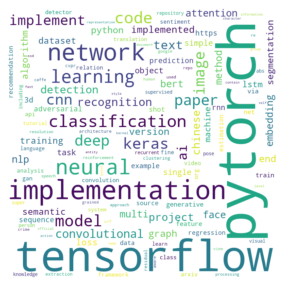

In [21]:
plot_word_cloud(China_descrip, 'China_word_cloud')

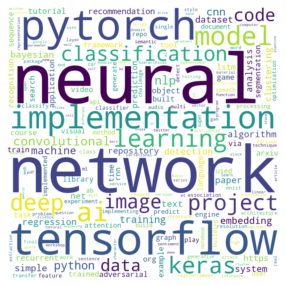

In [23]:
plot_word_cloud(US_descrip, 'US_word_cloud')

In [515]:
def word_cloud_each_cluster(descrip, percentile):
    descrip_cluster=defaultdict()
    for repo_id in repo_clusters_no_events[percentile]:
        descrip_cluster[repo_id]=descrip[repo_id]
    return descrip_cluster

    

In [516]:
US_descrip_25=word_cloud_each_cluster(US_descrip, '25_percentile_US')
US_descrip_50=word_cloud_each_cluster(US_descrip, '50_percentile_US')
US_descrip_75=word_cloud_each_cluster(US_descrip, '75_percentile_US')
US_descrip_100=word_cloud_each_cluster(US_descrip, '100_percentile_US')
China_descrip_25=word_cloud_each_cluster(China_descrip, '25_percentile_China')
China_descrip_50=word_cloud_each_cluster(China_descrip, '50_percentile_China')
China_descrip_75=word_cloud_each_cluster(China_descrip, '75_percentile_China')
China_descrip_100=word_cloud_each_cluster(China_descrip, '100_percentile_China')

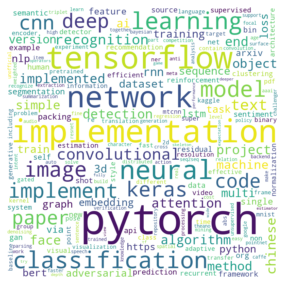

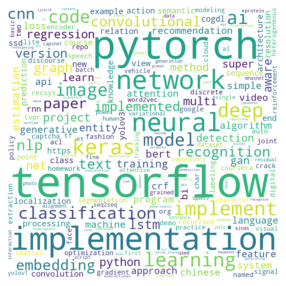

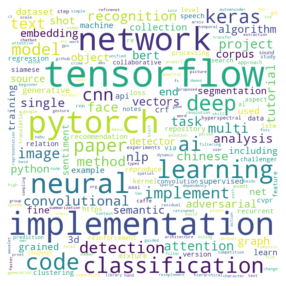

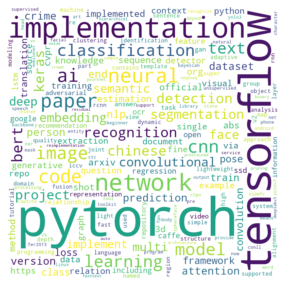

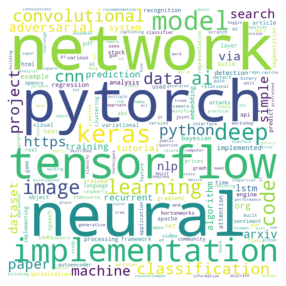

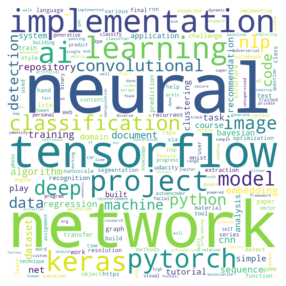

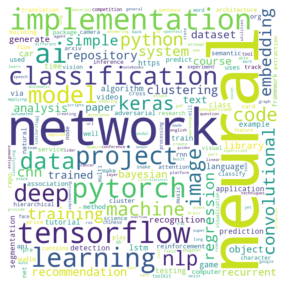

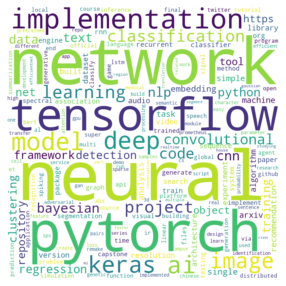

In [521]:
plot_word_cloud(China_descrip_25, 'China_word_cloud_cluster_1')
plot_word_cloud(China_descrip_50, 'China_word_cloud_cluster_2')
plot_word_cloud(China_descrip_75, 'China_word_cloud_cluster_3')
plot_word_cloud(China_descrip_100, 'China_word_cloud_cluster_4')


plot_word_cloud(US_descrip_25, 'US_word_cloud_cluster_1')
plot_word_cloud(US_descrip_50, 'US_word_cloud_cluster_2')
plot_word_cloud(US_descrip_75, 'US_word_cloud_cluster_3')
plot_word_cloud(US_descrip_100, 'US_word_cloud_cluster_4')

## Feature Extraction

### 1) LDA Topic Modeling 

In [90]:
#put all description in docs 
docs=[]
docs_w_id=defaultdict()
for repo_id in China_descrip:
    docs.append(China_descrip[repo_id])
    docs_w_id[repo_id]=China_descrip[repo_id]
    
for repo_id in US_descrip:
    docs.append(US_descrip[repo_id])
    docs_w_id[repo_id]=US_descrip[repo_id]
    

In [91]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    #docs[idx] = word_tokenize(docs[idx].lower())  # Convert to lowercase.
    docs[idx] = docs[idx].lower()
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
    
for repo_id in docs_w_id:
    #docs_w_id[repo_id] = word_tokenize(docs_w_id[repo_id].lower())  # Convert to lowercase.
    docs_w_id[repo_id] = docs_w_id[repo_id].lower()
    docs_w_id[repo_id] = tokenizer.tokenize(docs_w_id[repo_id])  # Split into words.


# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

for repo_id in docs_w_id:
    docs_w_id[repo_id]=[token for token in docs_w_id[repo_id]]
    

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

for repo_id in docs_w_id:
    docs_w_id[repo_id]=[token for token in docs_w_id[repo_id] if len(token) > 1]
    


In [92]:
#remove stop words
docs = [[token for token in doc if token not in stopwords] for doc in docs]

for repo_id in docs_w_id:
     docs_w_id[repo_id]=[token for token in docs_w_id[repo_id] if token not in stopwords]
    

In [93]:
# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_above=0.6)


In [94]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

corpus_w_id=defaultdict()
for repo_id in docs_w_id:
    corpus_w_id[repo_id]=dictionary.doc2bow(docs_w_id[repo_id])

In [95]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 613
Number of documents: 2576


In [96]:
# running LAD 

# Set training parameters.
num_topics = 2 #number of topics is set to 2 with this intuition that we aim to do topic modeling for two country-based repos
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [97]:
get_document_topics = [model.get_document_topics(item) for item in corpus]

get_document_topics_w_id=defaultdict()
for repo_id in corpus_w_id:
    get_document_topics_w_id[repo_id]= model.get_document_topics(corpus_w_id[repo_id])


In [98]:
#repos topic distribution 
for repo_id in get_document_topics_w_id:
    get_document_topics_w_id[repo_id]=[item[1] for item in get_document_topics_w_id[repo_id]]
    

In [99]:
get_document_topics_w_id

defaultdict(None,
            {103733627: [0.42193776, 0.5780622],
             177148468: [0.1970828, 0.8029172],
             129873306: [0.48480225, 0.51519775],
             126170223: [0.4671928, 0.5328072],
             171679268: [0.36187664, 0.63812333],
             171679858: [0.72690016, 0.27309984],
             214991093: [0.254679, 0.745321],
             142151256: [0.21733685, 0.78266317],
             154923689: [0.53399307, 0.46600693],
             139585111: [0.5301465, 0.46985352],
             121198049: [0.18087785, 0.81912214],
             190349058: [0.16385847, 0.8361415],
             149237157: [0.40419045, 0.59580964],
             191671736: [0.30265447, 0.6973455],
             130851696: [0.26253682, 0.7374631],
             142463407: [0.51562715, 0.4843729],
             97328390: [0.52591866, 0.47408134],
             171561804: [0.63093203, 0.3690679],
             111216699: [0.15959826, 0.8404017],
             111217131: [0.21931209, 0.7806879],


In [100]:
# top words for each topic
top_topics = model.top_topics(corpus, topn=20) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
#print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

[([(0.066383526, 'tensorflow'),
   (0.063933246, 'pytorch'),
   (0.058157217, 'implementation'),
   (0.031318374, 'learning'),
   (0.030473283, 'keras'),
   (0.027755968, 'classification'),
   (0.027752163, 'deep'),
   (0.015951218, 'cnn'),
   (0.015051222, 'image'),
   (0.014141024, 'model'),
   (0.01157465, 'models'),
   (0.011193525, 'text'),
   (0.011156769, 'paper'),
   (0.010404292, 'python'),
   (0.010199066, 'embedding'),
   (0.010158746, 'detection'),
   (0.009896037, 'clustering'),
   (0.009340334, 'networks'),
   (0.00862935, 'bayesian'),
   (0.0074646007, 'simple')],
  -5.233805496891559),
 ([(0.09213041, 'neural'),
   (0.050566882, 'network'),
   (0.039768305, 'ai'),
   (0.03490444, 'networks'),
   (0.027629487, 'project'),
   (0.021975316, 'convolutional'),
   (0.021667233, 'code'),
   (0.0199404, 'nlp'),
   (0.01796339, 'data'),
   (0.010522533, 'analysis'),
   (0.010442666, 'machine'),
   (0.010213181, 'regression'),
   (0.009731945, 'images'),
   (0.009248657, 'trainin

### 2) feature distribution for visualization

In [114]:
def write_file(x, filename):
    f=open(filename, 'w')
    for value in x:
        f.write(str(value))
        f.write('\n')
    f.close()

In [113]:
# topic distribution

In [101]:
#dictionary to pandas
topic_dist_pd=pd.DataFrame.from_dict(get_document_topics_w_id, orient='index', columns=['tpc_1', 'tpc_2'])

In [102]:
#locate NaN values
is_NaN = topic_dist_pd.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = topic_dist_pd[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [tpc_1, tpc_2]
Index: []


In [103]:
#replace NaN values with 0
topic_dist_pd['tpc_1'] = topic_dist_pd['tpc_1'].fillna(0)
topic_dist_pd['tpc_2'] = topic_dist_pd['tpc_2'].fillna(0)

In [104]:
topic_dist_pd['repo_id']=topic_dist_pd.index

In [120]:
a=list(repo_features[repo_features.Label==1]['tpc_2'])
b=list(repo_features[repo_features.Label==0]['tpc_2'])

In [111]:
a=list(topic_dist_pd[topic_dist_pd.repo_id.isin(US_repo_ids)]['tpc_1'])#tpc_1 US, tpc_2 China
b=list(topic_dist_pd[topic_dist_pd.repo_id.isin(China_repo_ids)]['tpc_1'])

In [119]:
write_file(a,'US_topic_1_dist.txt')
write_file(b,'China_topic_1_dist.txt')

In [112]:
a=list(topic_dist_pd[topic_dist_pd.repo_id.isin(US_repo_ids)]['tpc_2'])
b=list(topic_dist_pd[topic_dist_pd.repo_id.isin(China_repo_ids)]['tpc_2'])

In [121]:
write_file(a,'US_topic_2_dist.txt')
write_file(b,'China_topic_2_dist.txt')

star_count & watchers_count are same

In [94]:
def ExtractFeature(feature_name):
    a=list(repo_pd[repo_pd.repo_country=='USA'][feature_name]+1)
    b=list(repo_pd[repo_pd.repo_country=='China'][feature_name]+1)
    return a,b

In [95]:
a,b=ExtractFeature('star_count')

In [96]:
write_file(a,'US_star_count.txt')
write_file(b,'China_star_count.txt')

In [277]:
a,b=ExtractFeature('forks_count')

In [278]:
write_file(a,'US_fork_count.txt')
write_file(b,'China_fork_count.txt')

In [279]:
a,b=ExtractFeature('open_issues_count')

In [280]:
write_file(a,'US_open_issues_count.txt')
write_file(b,'China_open_issues_count.txt')

##### Take-away features like no.star, no.issue and no.fork have significant different distribution across country 

### 3) Commit info & length of comments

In [20]:
#history of commits 
commit_history=glob.glob("/lfs1/GitHubAPI/repos/commit_info/*.txt")
print (len(commit_history))

#take first zero to initiate dataframe
repo_id=commit_history[0].split('/')[-1][:-4]
data = pd.read_csv(commit_history[0], sep="\t", names=['commit_hash','author', 'author_time', 'commiter_name', 'commiter_time', 'comment'])
repo_id=len(data)*[repo_id]
data.insert(0, "repo_id", repo_id, True) 

#add repos to initiall data frame
for file in tqdm(commit_history[1:]):
    repo_id=file.split('/')[-1][:-4]
    data_ = pd.read_csv(file, sep="\t", names=['commit_hash','author', 'author_time', 'commiter_name', 'commiter_time', 'comment'])
    repo_id=len(data_)*[repo_id]
    data_.insert(0, "repo_id", repo_id, True)
    frames=[data, data_]
    data=pd.concat(frames)
    



  0%|          | 0/7424 [00:00<?, ?it/s]

7425


100%|██████████| 7424/7424 [07:46<00:00, 15.91it/s]


In [25]:
#data.to_pickle('commit_history.pickle')
data=pd.read_pickle('commit_history.pickle')

In [27]:
# covert string to an integer 
data['repo_id'] = data['repo_id'].astype(int) 

In [28]:
#filter commits on US and China repos
comment_US=data[data.repo_id.isin(US_repo_ids)][['repo_id', 'comment']]
comment_China=data[data.repo_id.isin(China_repo_ids)][['repo_id', 'comment']]

In [30]:
len(comment_US), len(comment_China)

(140249, 61154)

In [32]:
# length of comments and check for zh characters + translation
def Extract_commen_len(data):
    ct= 0
    comment_len=defaultdict(list)
    for row in tqdm(data.iterrows()):
        try:            
            a=row[1]['comment']
            lan=langid.classify(a)
            if lan[0]=='zh':
                translated = translator.translate(row[1]['comment'])
                l=len(translated.text.split())
            else:
                l=len(row[1]['comment'].split())

            comment_len[row[1]['repo_id']].append(l)    

        except:
            ct+=1
    print (ct)
    return comment_len
        



In [33]:
comment_len_US=Extract_commen_len (comment_US)
comment_len_China=Extract_commen_len (comment_China)

140249it [02:51, 819.29it/s]
64it [00:00, 639.88it/s]

0


61154it [10:39, 95.68it/s] 

81


In [38]:
comment_len_US = {k:mean(v) for k,v in comment_len_US.items()}
comment_len_China = {k:mean(v) for k,v in comment_len_China.items()}

In [45]:
write_file(list(comment_len_US.values()), 'us_commit_comment.txt')
write_file(list(comment_len_China.values()), 'china_commit_comment.txt')

### 4) Logistic Regression 

In [47]:
len(event_pd)

2078098

In [302]:
X=event_pd[event_pd.event_type!='WatchEvent'][['repo_id', 'event_type']].groupby('repo_id')['event_type'].apply(list)
#X=event_pd[['repo_id', 'event_type']].groupby('repo_id')['event_type'].apply(list)
repo_events=pd.DataFrame({'repo_id':X.index, 'events':X.values})

X=event_pd[event_pd.event_type=='WatchEvent'][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
repo_watcher=pd.DataFrame({'repo_id':X.index, 'actor_id':X.values})

X=event_pd[event_pd.event_type!='WatchEvent'][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
repo_contributor=pd.DataFrame({'repo_id':X.index, 'actor_id':X.values})


In [303]:
len(repo_contributor), len(repo_watcher), len(event_pd), len(repo_events)

(7424, 6103, 2078098, 7424)

#### percentage of events


In [304]:
repo_events_features=defaultdict()

for row in tqdm(repo_events.iterrows()):
    events_percentage={'PushEvent':0, 'ForkEvent':0, 'IssueCommentEvent':0, 'IssuesEvent':0, 'PullRequestEvent':0, 'CreateEvent':0,
  'PullRequestReviewCommentEvent':0, 'DeleteEvent':0, 'GollumEvent':0, 'MemberEvent':0, 'ReleaseEvent':0,
   'CommitCommentEvent':0, 'PublicEvent':0}

    a=dict(Counter(row[1]['events']))
    #normalization
    a = {k: v / len(row[1]['events']) for k, v in a.items()}
    for event in a:
        events_percentage[event]=a[event]
    repo_events_features[row[1]['repo_id']]=events_percentage

7424it [00:01, 5987.20it/s]


#### Jaccard 

In [305]:
#jaccard similarity between contributors and watchers
#merge repo_watcher and repo_contributor
repo_watcher_contributor=repo_contributor.merge(repo_watcher[['repo_id', 'actor_id']], left_on='repo_id', right_on='repo_id', how='left')
#rename columns
repo_watcher_contributor.rename(columns={'repo_id': 'repo_id', 'actor_id_x': 'contributor_id', 'actor_id_y':'watcher_id'}, inplace=True)

In [306]:
repo_watcher_contributor=repo_watcher_contributor[['repo_id', 'contributor_id', 'watcher_id']]

#replace nan with []
repo_watcher_contributor.loc[repo_watcher_contributor['watcher_id'].isnull(),['watcher_id']] = repo_watcher_contributor.loc[repo_watcher_contributor['watcher_id'].isnull(),'watcher_id'].apply(lambda watcher_id: [])

#calculate jaccard feature
repo_watcher_contributor['jaccard'] = repo_watcher_contributor.apply(lambda row: len(set(row.contributor_id).intersection(set(row.watcher_id)))/len(set(row.contributor_id).union(set(row.watcher_id))) , axis=1)


#### length of comments

In [57]:
comment_len = dict(list(comment_len_US.items()) + list(comment_len_China.items()))

#### number of leaders


In [308]:
#Distribution of number of unique users with pull request and push events (or non-watcher users)
repo_leaders=event_pd[(event_pd.event_type=='PushEvent') | (event_pd.event_type=='PullRequestEvent')][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
repo_leaders=pd.DataFrame({'repo_id':repo_leaders.index, 'actor_ids':repo_leaders.values})
repo_leaders['num_leaders'] = repo_leaders.apply(lambda row: len(set(row.actor_ids)), axis=1)
repo_leaders=repo_leaders.drop(['actor_ids'], axis=1)


In [309]:
len(repo_leaders)

7397

#### merge features into repo_features

In [158]:
#put all the features along with repo_id in one dataframe

In [310]:
repo_features=pd.DataFrame.from_dict(repo_events_features, orient='index')

In [311]:
repo_features['repo_id']=repo_features.index

In [312]:
repo_count_features=repo_pd[['repo_id', 'star_count', 'forks_count', 'open_issues_count']]

In [313]:
#merge repo_features and repo_count_features
repo_features=repo_features.merge(repo_count_features[['repo_id', 'star_count', 'forks_count', 'open_issues_count']], left_on='repo_id', right_on='repo_id', how='left')

In [314]:
#merge repo_features and jaccard
repo_features=repo_features.merge(repo_watcher_contributor[['repo_id', 'jaccard']], left_on='repo_id', right_on='repo_id', how='left')


In [315]:
#merge repo_features and repo_leader
repo_features=repo_features.merge(repo_leaders[['repo_id', 'num_leaders']], left_on='repo_id', right_on='repo_id', how='left')
#fill nan for num_leaders with zeros
repo_features['num_leaders'] = repo_features['num_leaders'].fillna(0)

In [59]:
#merge repo_features and comment len
CommentLen=[]
ct=0
for row in repo_features.iterrows():
    if row[1]['repo_id'] in comment_len:
        CommentLen.append(comment_len[row[1]['repo_id']])
        ct+=1
    else:
        CommentLen.append (0)
    

In [317]:
repo_features['CommentLen']=CommentLen

In [318]:
#merge repo_features and iat
#repo_iat_med
iat=[]
for row in repo_features.iterrows():
    iat.append(repo_iat_med[row[1]['repo_id']])

In [319]:
repo_features['iat']=iat

In [320]:
#merge repo_features with sequence latent vectors
repo_sequence=pd.read_pickle('latent_vectors_general.pickle')

In [323]:
repo_features=repo_features.merge(repo_sequence, left_on='repo_id', right_on='repo_id', how='left')

In [ ]:
# repo_features=repo_features.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
#                    31,32,33,34,35,36,37,38,39], axis = 1)

In [ ]:
#merge repo_features with topic distribution 

In [328]:
repo_features=repo_features.merge(topic_dist_pd, left_on='repo_id', right_on='repo_id', how='left')

#### normalization of 'star_count', 'forks_count', 'open_issues_count', 'CommentLen', 'num_leaders'

In [330]:
#+1 for log(0+1)
repo_features['star_count_normal']=np.log(repo_features['star_count']+1)
repo_features['forks_count_normal']=np.log(repo_features['forks_count']+1)
repo_features['open_issues_count_normal']=np.log(repo_features['open_issues_count']+1)

#### Label

In [331]:
label=[]
for row in repo_features.iterrows():
    if row[1]['repo_id'] in US_repo_ids:
        label.append(1)
    elif row[1]['repo_id'] in China_repo_ids:
        label.append(0)
    else:
        label.append(None)
repo_features['Label']=label

In [360]:
len(repo_features), len(label), label.count(0), label.count(1), repo_features.shape

(7424, 7424, 1125, 1451, (7424, 67))

In [2]:
#repo_features.to_pickle('repo_features.pickle')
# #read repo_features from file
repo_features=pd.read_pickle('repo_features.pickle')

In [19]:
#repo_features.columns

#### Classifier

In [38]:
def classify_repo_(repo_clusters, repo_features, percentile_US, percentile_China):
    df=repo_features[repo_features.repo_id.isin(set(repo_clusters[percentile_US]).union(set(repo_clusters[percentile_China])))]
    #impact of clustering
    #df=repo_features[repo_features.repo_id.isin(set(percentile_US).union(set(percentile_China)))]
    
    
    x = df.drop(['Label', 'repo_id', 'star_count', 'forks_count', 'open_issues_count'], axis = 1)
    
    emb_ftrs=set(range(0,40))
    X_emb=list(range(40))
    X_profile=['forks_count_normal','star_count_normal','open_issues_count_normal','num_leaders','CommentLen','jaccard','iat', 'tpc_1', 'tpc_2']
    X_act=['PushEvent','ForkEvent','IssueCommentEvent','IssuesEvent','PullRequestEvent','CreateEvent',
           'PullRequestReviewCommentEvent','DeleteEvent','GollumEvent','MemberEvent','ReleaseEvent','CommitCommentEvent',
           'PublicEvent']
  
    # ........ Leave one out 
#     x_columns=x.columns
#     for feature in x_columns:
#         if feature not in emb_ftrs:
#             print (feature)
#             X=x.drop([feature], axis=1)
    

    #............. Decision Stump 
    
    X = df.drop(['Label', 'repo_id', 'star_count', 'forks_count', 'open_issues_count'], axis = 1)
    
    #features=X_profile+X_act+X_emb
    #features=X_profile
    #features=X_act
    #features=X_emb
    
    #features=X_profile+X_act
    #features=X_profile+X_emb
    features=X_act+X_emb
    
    
    X=X[features]
 
    print (X.shape)
    y = df.Label
    #shuffle labels
    #y=np.random.permutation(y)
 


    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=4, test_size=0.3)
    
    #Random Forest
    #model = RandomForestClassifier()
    #param_grid = {'n_estimators': [2, 5, 10, 15],'max_depth': [2, 5, 7, 9]}
    
    
    #Decision Tree
#     model= DecisionTreeClassifier()
#     param_grid = {'max_depth': [2, 5, 7, 9]}
    
#     grid_model = GridSearchCV(model, param_grid, cv=5)
#     grid_model.fit(x_train, y_train)
#     model=grid_model.best_estimator_
#     print (model)

    
    #logistic regression
    model = LogisticRegressionCV(cv=5, max_iter=10000)
    model.fit(x_train, y_train)
    print (model)


    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #accuracy_percentage = 100 * accuracy

    print ('accuracy: ', accuracy , '\n')

#     print (confusion_matrix(y_test, y_pred))
#     print(precision_recall_fscore_support(y_test, y_pred, average=None, labels=[1,0]))
#     print(precision_recall_fscore_support(y_test, y_pred, average='weighted', labels=[1,0]))





In [63]:
#shuffle labels
for i in range(5):
    classify_repo_(repo_clusters_no_events, repo_features, '100_percentile_US', '100_percentile_China')

(623, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7540106951871658 

(623, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7540106951871658 

(623, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7540106951871658 

(623, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7540106951871658 

(623, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7540106951871658 



In [21]:
#Logistic Regression

In [22]:
classify_repo_(repo_clusters_no_events, repo_features, '25_percentile_US', '25_percentile_China')

(751, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.6858407079646017 

[[103  20]
 [ 51  52]]
(array([0.72222222, 0.66883117]), array([0.50485437, 0.83739837]), array([0.59428571, 0.74368231]), array([103, 123]))
(0.6931642595359409, 0.6858407079646017, 0.6755944812351955, None)


In [23]:
classify_repo_(repo_clusters_no_events, repo_features, '50_percentile_US', '50_percentile_China')

(593, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7471910112359551 

[[48 24]
 [21 85]]
(array([0.77981651, 0.69565217]), array([0.80188679, 0.66666667]), array([0.79069767, 0.68085106]), array([106,  72]))
(0.7457725111261501, 0.7471910112359551, 0.7462653375512179, None)


In [24]:
classify_repo_(repo_clusters_no_events, repo_features, '75_percentile_US', '75_percentile_China')

(609, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7923497267759563 

[[ 44  15]
 [ 23 101]]
(array([0.87068966, 0.65671642]), array([0.81451613, 0.74576271]), array([0.84166667, 0.6984127 ]), array([124,  59]))
(0.8017037480770259, 0.7923497267759563, 0.7954809610547317, None)


In [25]:
classify_repo_(repo_clusters_no_events, repo_features, '100_percentile_US', '100_percentile_China')

(623, 62)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7540106951871658 

[[53 31]
 [15 88]]
(array([0.7394958 , 0.77941176]), array([0.85436893, 0.63095238]), array([0.79279279, 0.69736842]), array([103,  84]))
(0.7574259650384219, 0.7540106951871658, 0.7499283691234155, None)


In [452]:
#Random Forest

In [473]:
classify_repo_(repo_clusters_no_events, repo_features, '25_percentile_US', '25_percentile_China')

(751, 62)
RandomForestClassifier(max_depth=7, n_estimators=15)
accuracy:  0.6769911504424779 

[[101  22]
 [ 51  52]]
(array([0.7027027 , 0.66447368]), array([0.50485437, 0.82113821]), array([0.58757062, 0.73454545]), array([103, 123]))
(0.6818966439658103, 0.6769911504424779, 0.667561349205267, None)


In [469]:
classify_repo_(repo_clusters_no_events, repo_features, '50_percentile_US', '50_percentile_China')

(593, 62)
RandomForestClassifier(max_depth=7, n_estimators=10)
accuracy:  0.7303370786516854 

[[45 27]
 [21 85]]
(array([0.75892857, 0.68181818]), array([0.80188679, 0.625     ]), array([0.77981651, 0.65217391]), array([106,  72]))
(0.7277378520356048, 0.7303370786516854, 0.7281857988643036, None)


In [474]:
classify_repo_(repo_clusters_no_events, repo_features, '75_percentile_US', '75_percentile_China')

(609, 62)
RandomForestClassifier(max_depth=2, n_estimators=15)
accuracy:  0.7814207650273224 

[[ 38  21]
 [ 19 105]]
(array([0.83333333, 0.66666667]), array([0.84677419, 0.6440678 ]), array([0.84      , 0.65517241]), array([124,  59]))
(0.7795992714025501, 0.7814207650273224, 0.7804107782174486, None)


In [475]:
classify_repo_(repo_clusters_no_events, repo_features, '100_percentile_US', '100_percentile_China')

(623, 62)
RandomForestClassifier(max_depth=5, n_estimators=15)
accuracy:  0.7379679144385026 

[[53 31]
 [18 85]]
(array([0.73275862, 0.74647887]), array([0.82524272, 0.63095238]), array([0.77625571, 0.68387097]), array([103,  84]))
(0.7389217287868831, 0.7379679144385026, 0.7347566801597111, None)


In [ ]:
#Decision Tree

In [484]:
classify_repo_(repo_clusters_no_events, repo_features, '25_percentile_US', '25_percentile_China')

(751, 62)
DecisionTreeClassifier(max_depth=2)
accuracy:  0.668141592920354 

[[74 49]
 [26 77]]
(array([0.61111111, 0.74      ]), array([0.74757282, 0.60162602]), array([0.67248908, 0.66367713]), array([103, 123]))
(0.6812586037364798, 0.668141592920354, 0.6676931970856957, None)


In [485]:
classify_repo_(repo_clusters_no_events, repo_features, '50_percentile_US', '50_percentile_China')

(593, 62)
DecisionTreeClassifier(max_depth=2)
accuracy:  0.7640449438202247 

[[52 20]
 [22 84]]
(array([0.80769231, 0.7027027 ]), array([0.79245283, 0.72222222]), array([0.8       , 0.71232877]), array([106,  72]))
(0.7652246023032541, 0.7640449438202247, 0.764537478836386, None)


In [486]:
classify_repo_(repo_clusters_no_events, repo_features, '75_percentile_US', '75_percentile_China')

(609, 62)
DecisionTreeClassifier(max_depth=2)
accuracy:  0.7486338797814208 

[[ 30  29]
 [ 17 107]]
(array([0.78676471, 0.63829787]), array([0.86290323, 0.50847458]), array([0.82307692, 0.56603774]), array([124,  59]))
(0.7388983497130976, 0.7486338797814208, 0.7402063654460809, None)


In [487]:
classify_repo_(repo_clusters_no_events, repo_features, '100_percentile_US', '100_percentile_China')

(623, 62)
DecisionTreeClassifier(max_depth=2)
accuracy:  0.7486631016042781 

[[64 20]
 [27 76]]
(array([0.79166667, 0.7032967 ]), array([0.73786408, 0.76190476]), array([0.7638191 , 0.73142857]), array([103,  84]))
(0.7519710681475387, 0.7486631016042781, 0.7492693413592024, None)


In [423]:
#impact of clustering
classify_repo_(repo_clusters_no_events, repo_features, US_repo_ids, China_repo_ids)

(2576, 62)
accuracy:  0.7141009055627425 

[[235 107]
 [114 317]]
(array([0.74764151, 0.67335244]), array([0.73549884, 0.6871345 ]), array([0.74152047, 0.68017366]), array([431, 342]))
(0.7147736397378099, 0.7141009055627425, 0.7143786724743413, None)


#### Decision Stump

In [39]:
classify_repo_(repo_clusters_no_events, repo_features, '25_percentile_US', '25_percentile_China')
classify_repo_(repo_clusters_no_events, repo_features, '50_percentile_US', '50_percentile_China')
classify_repo_(repo_clusters_no_events, repo_features, '75_percentile_US', '75_percentile_China')
classify_repo_(repo_clusters_no_events, repo_features, '100_percentile_US', '100_percentile_China')

(751, 53)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.6371681415929203 

(593, 53)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7078651685393258 

(609, 53)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7213114754098361 

(623, 53)
LogisticRegressionCV(cv=5, max_iter=10000)
accuracy:  0.7272727272727273 



#### Leave one out 

In [414]:
classify_repo_(repo_clusters_no_events, repo_features, '25_percentile_US', '25_percentile_China')

PushEvent
(751, 61)
accuracy:  0.6814159292035398 

ForkEvent
(751, 61)
accuracy:  0.6858407079646017 

IssueCommentEvent
(751, 61)
accuracy:  0.6814159292035398 

IssuesEvent
(751, 61)
accuracy:  0.6858407079646017 

PullRequestEvent
(751, 61)
accuracy:  0.6858407079646017 

CreateEvent
(751, 61)
accuracy:  0.6858407079646017 

PullRequestReviewCommentEvent
(751, 61)
accuracy:  0.6858407079646017 

DeleteEvent
(751, 61)
accuracy:  0.6858407079646017 

GollumEvent
(751, 61)
accuracy:  0.6858407079646017 

MemberEvent
(751, 61)
accuracy:  0.6858407079646017 

ReleaseEvent
(751, 61)
accuracy:  0.6858407079646017 

CommitCommentEvent
(751, 61)
accuracy:  0.6858407079646017 

PublicEvent
(751, 61)
accuracy:  0.6858407079646017 

jaccard
(751, 61)
accuracy:  0.6814159292035398 

num_leaders
(751, 61)
accuracy:  0.7079646017699115 

CommentLen
(751, 61)
accuracy:  0.6327433628318584 

iat
(751, 61)
accuracy:  0.6814159292035398 

tpc_1
(751, 61)
accuracy:  0.6814159292035398 

tpc_2
(751, 61

In [415]:
classify_repo_(repo_clusters_no_events, repo_features, '50_percentile_US', '50_percentile_China')

PushEvent
(593, 61)
accuracy:  0.7640449438202247 

ForkEvent
(593, 61)
accuracy:  0.7528089887640449 

IssueCommentEvent
(593, 61)
accuracy:  0.7640449438202247 

IssuesEvent
(593, 61)
accuracy:  0.7471910112359551 

PullRequestEvent
(593, 61)
accuracy:  0.7752808988764045 

CreateEvent
(593, 61)
accuracy:  0.7471910112359551 

PullRequestReviewCommentEvent
(593, 61)
accuracy:  0.7752808988764045 

DeleteEvent
(593, 61)
accuracy:  0.7752808988764045 

GollumEvent
(593, 61)
accuracy:  0.7752808988764045 

MemberEvent
(593, 61)
accuracy:  0.7471910112359551 

ReleaseEvent
(593, 61)
accuracy:  0.7471910112359551 

CommitCommentEvent
(593, 61)
accuracy:  0.7471910112359551 

PublicEvent
(593, 61)
accuracy:  0.7752808988764045 

jaccard
(593, 61)
accuracy:  0.7696629213483146 

num_leaders
(593, 61)
accuracy:  0.7528089887640449 

CommentLen
(593, 61)
accuracy:  0.702247191011236 

iat
(593, 61)
accuracy:  0.797752808988764 

tpc_1
(593, 61)
accuracy:  0.7528089887640449 

tpc_2
(593, 61)


In [416]:
classify_repo_(repo_clusters_no_events, repo_features, '75_percentile_US', '75_percentile_China')

PushEvent
(609, 61)
accuracy:  0.7431693989071039 

ForkEvent
(609, 61)
accuracy:  0.726775956284153 

IssueCommentEvent
(609, 61)
accuracy:  0.7814207650273224 

IssuesEvent
(609, 61)
accuracy:  0.7814207650273224 

PullRequestEvent
(609, 61)
accuracy:  0.7868852459016393 

CreateEvent
(609, 61)
accuracy:  0.7923497267759563 

PullRequestReviewCommentEvent
(609, 61)
accuracy:  0.7923497267759563 

DeleteEvent
(609, 61)
accuracy:  0.7923497267759563 

GollumEvent
(609, 61)
accuracy:  0.7923497267759563 

MemberEvent
(609, 61)
accuracy:  0.7868852459016393 

ReleaseEvent
(609, 61)
accuracy:  0.7923497267759563 

CommitCommentEvent
(609, 61)
accuracy:  0.7923497267759563 

PublicEvent
(609, 61)
accuracy:  0.7923497267759563 

jaccard
(609, 61)
accuracy:  0.7704918032786885 

num_leaders
(609, 61)
accuracy:  0.7103825136612022 

CommentLen
(609, 61)
accuracy:  0.7377049180327869 

iat
(609, 61)
accuracy:  0.7759562841530054 

tpc_1
(609, 61)
accuracy:  0.7868852459016393 

tpc_2
(609, 61)

In [417]:
classify_repo_(repo_clusters_no_events, repo_features, '100_percentile_US', '100_percentile_China')#for this class embedding is doing well
#it may a good finding for case study 

PushEvent
(623, 61)
accuracy:  0.7540106951871658 

ForkEvent
(623, 61)
accuracy:  0.7540106951871658 

IssueCommentEvent
(623, 61)
accuracy:  0.7540106951871658 

IssuesEvent
(623, 61)
accuracy:  0.7540106951871658 

PullRequestEvent
(623, 61)
accuracy:  0.7540106951871658 

CreateEvent
(623, 61)
accuracy:  0.7540106951871658 

PullRequestReviewCommentEvent
(623, 61)
accuracy:  0.7540106951871658 

DeleteEvent
(623, 61)
accuracy:  0.7540106951871658 

GollumEvent
(623, 61)
accuracy:  0.7540106951871658 

MemberEvent
(623, 61)
accuracy:  0.7540106951871658 

ReleaseEvent
(623, 61)
accuracy:  0.7540106951871658 

CommitCommentEvent
(623, 61)
accuracy:  0.7540106951871658 

PublicEvent
(623, 61)
accuracy:  0.7540106951871658 

jaccard
(623, 61)
accuracy:  0.7540106951871658 

num_leaders
(623, 61)
accuracy:  0.732620320855615 

CommentLen
(623, 61)
accuracy:  0.7058823529411765 

iat
(623, 61)
accuracy:  0.7540106951871658 

tpc_1
(623, 61)
accuracy:  0.7540106951871658 

tpc_2
(623, 61)

In [ ]:
#get distributoin of othe features such as jaccard, iat, num_leaders, 

In [117]:
a=list(repo_features[repo_features.Label==1]['jaccard'])
b=list(repo_features[repo_features.Label==0]['jaccard'])

In [612]:
write_file(a,'US_jaccard_dist.txt')
write_file(b,'China_jaccard_dist.txt')

## Sequence Learning

In [144]:
event_time=pd.read_pickle('events_timestamp.pickle')# generated from events_extraction.py
event_time=event_time[event_time.repo_id.isin(set(repo_pd['repo_id']))]

In [126]:
#convert "%Y-%m-%d-%H" to unix
event_time['time_stamp'] = event_time.apply(lambda row: datetime.strptime(row.file_date, "%Y-%m-%d-%H").timestamp(), axis=1)

In [127]:
#index as col
event_time['index1'] = event_time.index

In [128]:
#sort row by time_stamp and index (to keep the order of events occured within same hour)
event_time=event_time.sort_values(by=['time_stamp', 'index1'])

In [129]:
len(event_time)

2078098

In [95]:
#filter watch events
event_time_w_o_watch=event_time[event_time.event_type!='WatchEvent']

In [96]:
len(event_time_w_o_watch)

1266284

In [13]:
#event_time.to_pickle('event_time.pickle')
#event_time_w_o_watch.to_pickle('event_time_w_o_watch.pickle')

In [130]:
event_time=pd.read_pickle('event_time.pickle')

In [131]:
#group by repo-id (event_type)
event_sequence=event_time[['repo_id', 'event_type']].groupby('repo_id')['event_type'].apply(list)
event_sequence=pd.DataFrame({'repo_id':event_sequence.index, 'event_type':event_sequence.values})

### IAT (inter arrival time)

In [132]:
#group by repo-id (event_time)
time_sequence=event_time[['repo_id', 'time_stamp']].groupby('repo_id')['time_stamp'].apply(list)#w/ watch
#time_sequence=event_time_w_o_watch[['repo_id', 'time_stamp']].groupby('repo_id')['time_stamp'].apply(list)#w/o watch
time_sequence=pd.DataFrame({'repo_id':time_sequence.index, 'time_stamp':time_sequence.values})

In [134]:
repo_iat_mean, repo_iat_med={}, {}
for row in time_sequence.iterrows():
    time_stamps=row[1]['time_stamp']
    tmp=[]
    for i in range(1, len(time_stamps)):
        tmp.append((time_stamps[i]-time_stamps[i-1])/86400.0)#in day/in hour
    repo_iat_mean[row[1]['repo_id']]=mean(tmp)
    repo_iat_med[row[1]['repo_id']]=np.median(tmp)
        
        
        

In [135]:
a_mean,b_mean, a_med, b_med=[],[], [], []
for repo_id in repo_iat_med:
    if repo_id in US_repo_ids:
        a_med.append(repo_iat_med[repo_id])
        a_mean.append(repo_iat_mean[repo_id])
    elif repo_id in China_repo_ids:
        b_med.append(repo_iat_med[repo_id])
        b_mean.append(repo_iat_mean[repo_id])
    
    
    

In [136]:
len(a_med), len(b_med), len(a_mean), len(b_mean)

(1451, 1125, 1451, 1125)

In [139]:
write_file(a_med,'US_iat_med.txt')
write_file(b_med,'China_iat_med.txt')

In [ ]:
#Done ! 